In [76]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [77]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash', google_api_key = os.getenv('GEMINI_KEY'))

In [78]:
from typing import Annotated, TypedDict, Annotated, Sequence
import operator, json
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults


In [79]:
@tool
def multiply(a:int, b:int)->int:
    """Multiply the two Integer"""
    return a*b

In [80]:
@tool
def search(query:str): 
    """Perform the web serach on user query"""
    tavily = TavilySearchResults()
    result = tavily.invoke(query)
    return result


In [81]:
search("who is the president of India currently ")

[{'title': 'President of India - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/President_of_India',
  'content': 'The president of India (ISO: Bhārata kē Rāṣṭrapati) is the head of state of the Republic of India. The president is the nominal head of the executive,[a] the first citizen of the country, as well as the supreme commander of the Indian Armed Forces. Droupadi Murmu is the 15th and current president, having taken office from 25 July 2022. [...] Jump to content\nMain menu\nSearch\nDonate\nCreate account\nLog in\nPersonal tools\nToggle the table of contents\nPresident of India\n70 languages\nArticle\nTalk\nRead\nView source\nView history\nTools\nFrom Wikipedia, the free encyclopedia\nFor a list of presidents, see List of presidents of India.\nPresident of India\nBhārata kē Rāṣṭrapati\nLogo of The President of India\nFlag of India\nIncumbent\nDroupadi Murmu\nsince\xa025 July 2022\nHead of state of the Republic of India\nExecutive branch of the Indian Government [...] making

In [82]:
tools = [search, multiply]

In [83]:
model_with_tools  = llm.bind_tools(tools)

In [92]:
tool_mapping = {tool.name:tool for tool in tools}

In [93]:
tool_mapping

{'search': StructuredTool(name='search', description='Perform the web serach on user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x7558e4b79360>),
 'multiply': StructuredTool(name='multiply', description='Multiply the two Integer', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x7558e4b79120>)}

In [95]:
resposne = model_with_tools.invoke("who is the president of India currently ")

In [96]:
resposne

AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "who is the president of India currently"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-9b1200f7-4995-413f-9d5b-628a6a12e794-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is the president of India currently'}, 'id': '9baf4023-0ff5-4834-9e75-7460f1b02327', 'type': 'tool_call'}], usage_metadata={'input_tokens': 28, 'output_tokens': 9, 'total_tokens': 37, 'input_token_details': {'cache_read': 0}})

In [102]:
tool_call = resposne.additional_kwargs.get("function_call")
print(tool_call)

{'name': 'search', 'arguments': '{"query": "who is the president of India currently"}'}


In [84]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], operator.add]

In [85]:
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]
    return {"messages":[model_with_tools.invoke(question)]}

In [94]:
def invoke_tool(state:AgentState):
    tool_details = state['messages'][-1].additional_kwargs.get('tool_calls', [])[0]

    if tool_details is None:
        raise Exception("no tool call found")
    print(f"selected_tool: {tool_details.get('function').get('name')}")

    if tool_details.get('function').get("name")=='search':
        resposne = input(prompt=f"[y/n] continue with expansive search")
        if resposne == 'n':
            raise Exception("web serach discard")
    resposne = tool_mapping[tool_details['function']["name"].invoke(json.loads(tool_details.get('function').get("arguments")))]
    return {'messages':[resposne]}

In [87]:
def router(state):
    tool_call=state['messages'][-1].additional_kwargs.get('tool_calls', [])
    print(tool_call)
    if len(tool_call):
        return "tool"
    else:
        return "end"

In [88]:
workflow = StateGraph(AgentState)
workflow.add_node("ai_assistant", invoke_model)
workflow.add_node('tool', invoke_tool)

workflow.add_conditional_edges("ai_assistant", router, {"tool":"tool", "end":END})
workflow.add_edge("tool", END)
workflow.set_entry_point('ai_assistant')

In [89]:
app = workflow.compile()

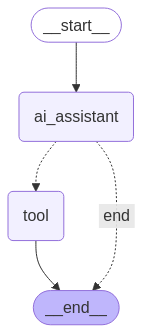

In [90]:
from IPython.display import Image, display
# View
display(Image(app.get_graph().draw_mermaid_png()))

In [91]:
app.invoke({"messages":["2*2"]})

[]


{'messages': ['2*2',
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-6b988894-9be3-49fb-bf5d-0787db5bbc51-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 2.0}, 'id': '5156a7b9-d7a1-482a-8bbb-f849b72cac80', 'type': 'tool_call'}], usage_metadata={'input_tokens': 23, 'output_tokens': 3, 'total_tokens': 26, 'input_token_details': {'cache_read': 0}})]}